In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10) # (w, h)



In [34]:
def extractdata(classification):
    " extract the  data given the path "
    data  = pd.read_csv(classification,sep = ' ', header=None, engine='python')
    X = data.as_matrix()[:,0:2]
    return X

X = extractdata('classification_data_HWK2/EMGaussian.data')

/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [55]:
# Definition of the gaussian density function with non isotropic covariance matrix
def gaussian(X, mu, sigma):
    """
    Computes the images of the rows of X by the gaussian of mean mu and covariance S
    
    Parameters
    ----------
    X : input matrix, of dimension (n, p). Each row represents an input
    mu : mean of the gaussian, of dimension p
    S : covariance of the gaussian
    Returns
    -------
    Array of size n containing the values
    """
    p = X.shape[1]
    Sinv = np.linalg.pinv(sigma)
    det = np.linalg.det(sigma)
    const = (1.0 / np.sqrt((2 * np.pi * det) ** p))
    return const * np.exp(-0.5 * np.einsum("ij,ij->i", (X - mu), Sinv.dot((X - mu).T).T))

def random_select(X, k):
    """
    Selects k random points among the observations
    """
    idx = np.random.randint(np.shape(X)[0], size = k)
    return X[idx]


def random_uniform(X, k):
    """ 
    Returns k points picked uniformly at random on the smallest rectangle containing all the observations
    """
    x0 = np.random.uniform(np.amin(X[:,0]),np.amax(X[:,0]) , k)
    y0 = np.random.uniform(np.amin(X[:,1]),np.amax(X[:,1]) , k)
    C0 = np.c_[x0, y0]
    return C0


class GMM(object):
    """
    Class for Gaussian mixture model.
    """
    
    def __int__(self):
        self.means = None
        self.sigmas = None
        self.weights = None
        self.log_likelihoods = None
        

    def log_likelihood(self, X, tau, pi, means, sigmas):
        """ 
        Log-likelihood of the GMM
        """
        p = np.shape(X)[1]
        n, K = np.shape(tau)
        res = np.sum(np.sum(tau))

        inverses = np.linalg.pinv(sigmas)
        dets = np.linalg.det(sigmas)    

        const = - np.log(2 * np.pi * dets) ** (p / 2)

        terms = tau * (np.log(pi) - p * np.log(dets)) + const - np.einsum('ik,kip -> ik', 
                                                                        tau, 
                    np.stack(np.dot(X - mu, np.dot(sinv, (X - mu).T)) for mu, sinv in zip(means, inverses)))

        return np.sum(np.sum(terms))

    def E_step(self, X, pi, means, sigmas):
        """
        Performs the E step on observations X using the current set of parameters
        """
        # Store a n * k matrix containing the image of each observation i by the j th gaussian, weighted by pi
        gaussian_values = np.vstack([pi[j] * gaussian(X, means[j], sigmas[j]) for j in range(pi.shape[0])]).T
        
        # Normalize these values with the sum along the second axis
        tau = np.einsum('i,ik->ik', 1.0 / np.sum(gaussian_values, axis = 1), gaussian_values)
        return tau
        
    def M_step(self, X, tau):
        """
        Performs the M step 
        """
        pi = np.mean(tau, axis = 0)
        means = np.einsum('k,kp->kp', 1.0 / np.sum(tau, axis=0), np.dot(tau.T, X))
        sigmas = np.einsum('k,klm->klm', 
                           1.0 / np.sum(tau, axis=0),
                           np.stack([np.dot(np.einsum('i,ik->ik', tau[:, j], X - mu).T, X - mu) for j,mu in enumerate(means)]))

        return pi, means, sigmas

    def fit(self, X, K=5, initialize_f=random_select, Niter=100, C0=None):
        """
        Trains the GMM sing the Expectation-Maximization algorithm.
        
        Parameters
        ----------
            X : Observations
            K : number of classes
            Niter : number of iterations

        Returns
        ------- 
            mu : Array containing the means of each class
            sigma : Array containing the standard deviations of each class
        """
        n, p = X.shape
        if C0 is not None:
            pi = np.random.rand(K)
            pi /= np.sum(pi)
            means = C0 # Initialize with set of means
        elif initialize_f is None:
        # Default: Random initialization
            pi = np.random.rand(K)
            pi /= np.sum(pi)
            means = X[np.random.randint(n, size=K)] # Pick K data points at random to initialize the means of the gaussians
        else:
            # Custom initialization
            pi = np.random.rand(K)
            pi /= np.sum(pi)
            means = initialize_f(X, K)

        # Initialize covariances
        sigmas = np.stack([np.identity(p) * (i + 1) for i in range(K)], axis = 0)
        
        
        # EM Loop
        log_likelihoods = []
        labels = range(K)
        for t in tqdm(range(Niter)):
            # E-step
            tau = self.E_step(X, pi, means, sigmas)
            # M-step
            pi, means, sigmas = self.M_step(X, tau)
            # Log Likelihood
            log_likelihoods.append(self.log_likelihood(X, tau, pi, means, sigmas))
            
        self.pi = pi
        self.means = means
        self.sigmas = sigmas
        self.log_likelihoods = log_likelihoods
        
        return means, sigmas, log_likelihoods
    
    def predict(self, X_t):
        """
        Predicts the most likely class for each element in X_t  
        """
        gaussian_values = np.vstack([gaussian(X_t, self.means[j], self.sigmas[j]) for j in range(self.means.shape[0])])
        return np.argmin(gaussian_values, axis=0)
    


100%|██████████| 40/40 [00:00<00:00, 87.20it/s]

Text(0.5,1,'Log-likelihood')

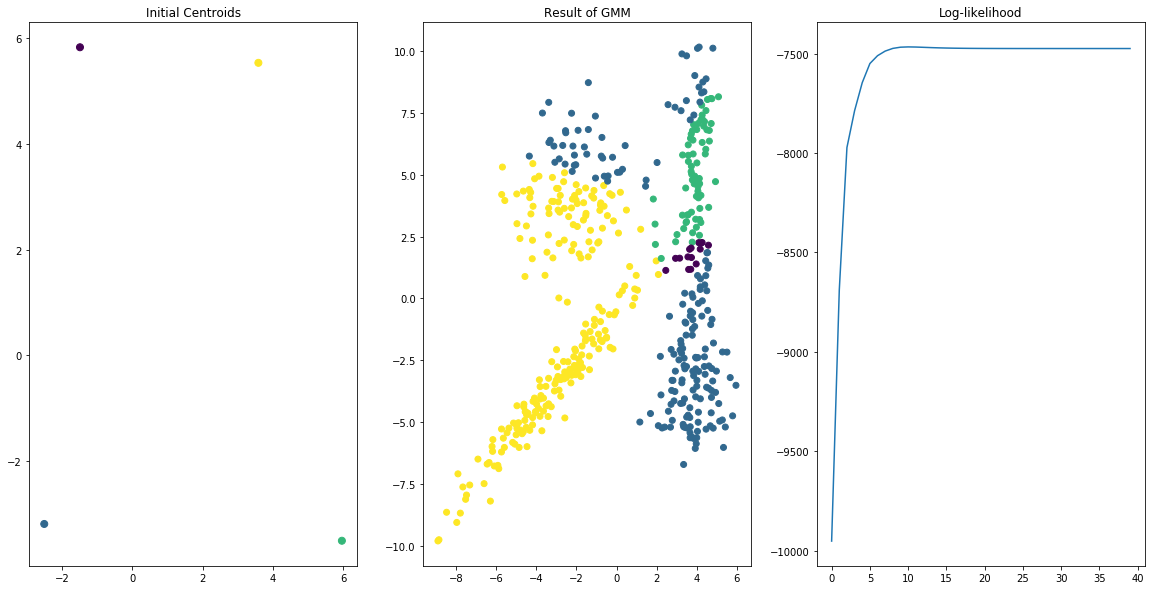

In [47]:

n_classes = 4


C0 = random_select(X, n_classes)

gmm = GMM()
means, sigmas, log_likelihoods = gmm.fit(X, n_classes, Niter=40, C0=C0)
labels = gmm.predict(X)

f, (ax1, ax2, ax3) = plt.subplots(1, 3)

colors = np.array(range(n_classes))
ax1.scatter(C0[:,0], C0[:,1], c=colors, s=49)
ax1.set_title('Initial Centroids')

ax2.scatter(X[:,0], X[:,1], c=labels)
ax2.set_title('Result of GMM')

ax3.plot(log_likelihoods)
ax3.set_title('Log-likelihood')

